In [2]:
from adapter import T2IAdapter
from pipeline_xl_adapter import StableDiffusionXLAdapterPipeline
import torch
from controlnet_aux import SamDetector
from PIL import Image
import urllib
from torchvision import transforms

/home/sargezt/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-08-02 20:55:34,584] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-08-02 20:55:35.005499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 20:55:35.721898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-02 20:55:35.721957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-02 20:55:35.721963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
resolution = 1024

In [12]:
dtype = torch.float16
device = "cuda"
adapter = T2IAdapter.from_pretrained("SargeZT/t2i-adapter-sdxl-segmentation").to(dtype=dtype, device=device)
pipe = StableDiffusionXLAdapterPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16", adapter=adapter).to(device)


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


In [6]:
import gc
del pipe
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()
torch.cuda.synchronize()
torch.cuda.empty_cache()
torch.cuda.synchronize()
gc.collect()

/home/sargezt/mambaforge/lib/python3.10/site-packages/torch/cuda/memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/sargezt/mambaforge/lib/python3.10/site-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


0

In [7]:
sam = SamDetector.from_pretrained("ybelkada/segment-anything", subfolder="checkpoints")

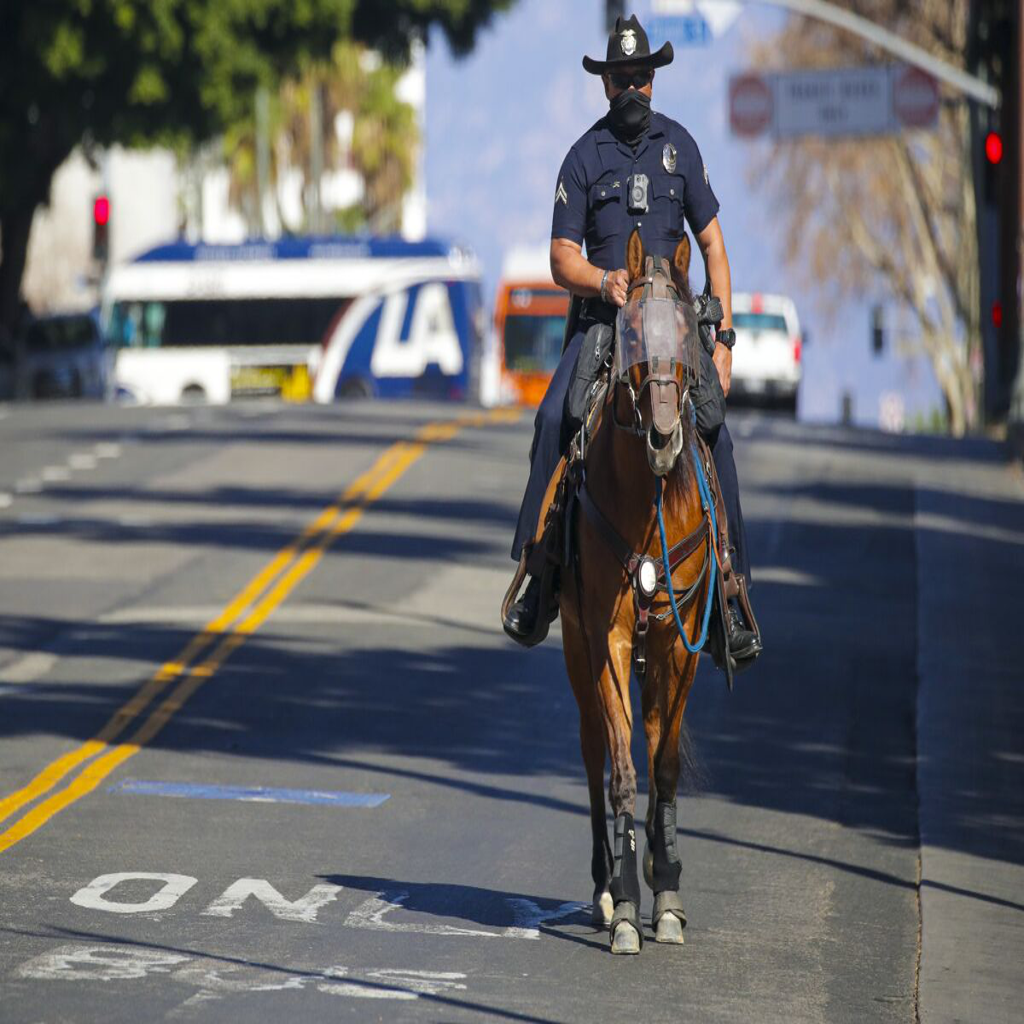

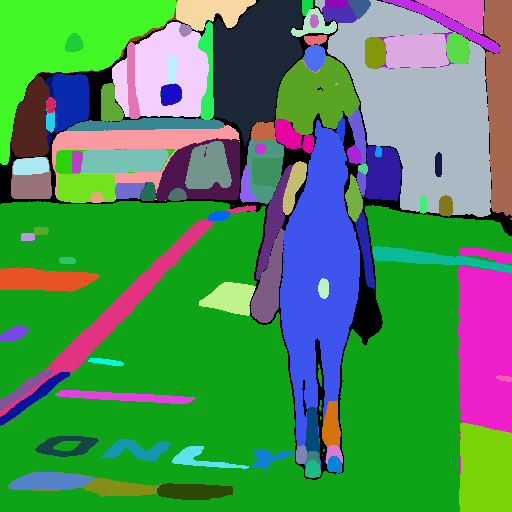

In [8]:
input_url = "https://ca-times.brightspotcdn.com/dims4/default/167bfeb/2147483647/strip/true/crop/2400x1600+0+0/resize/1200x800!/quality/80/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fb9%2F06%2F58ccf43e4162bd2115c662cc087e%2Fla-photos-1staff-692345-me-0120-heightened-alert-dtla12.IK.JPG"
with urllib.request.urlopen(input_url) as url:
    with open('input.jpg', 'wb') as f:
        f.write(url.read())
input_image = Image.open("input.jpg")

new_size = (resolution, resolution)
input_image = input_image.resize(new_size)

display(input_image)

# Segment the image
preprocessed_image = sam(input_image)
display(preprocessed_image)

In [9]:
transform = transforms.Compose([
    transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.BILINEAR,
        ),
        transforms.CenterCrop(resolution),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(dtype=dtype),
])
preprocessed_image_t = transform(preprocessed_image).unsqueeze(0)

In [ ]:
#print(preprocessed_image_t.shape)
adapter.to(pipe.unet.device).to(pipe.unet.dtype)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


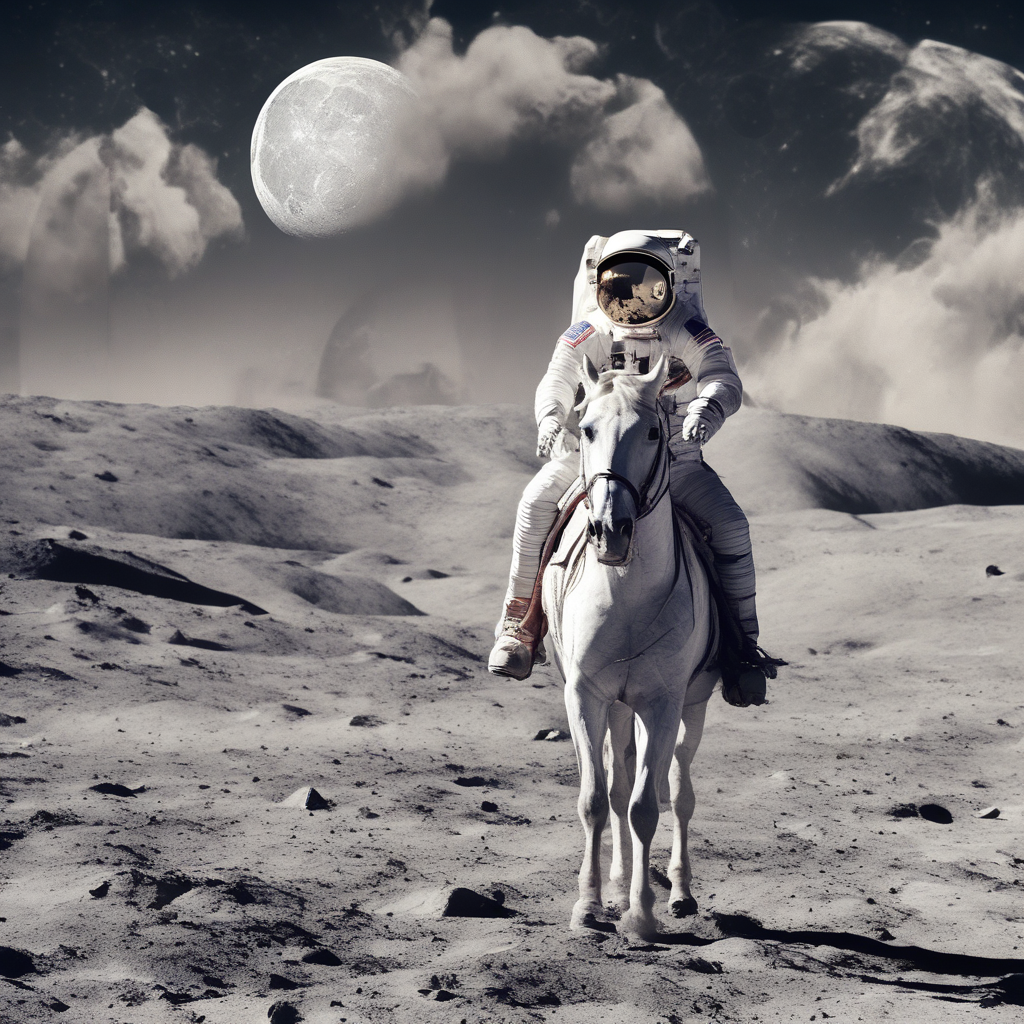

In [18]:
prompt = "An astronaut riding a horse on the moon."

images = pipe(prompt=prompt, height=resolution, width=resolution, image=preprocessed_image_t, guidance_scale=7.0).images[0]
display(images)